# Settings

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from ydata_profiling import ProfileReport

from sklearn import metrics
import scipy as sci

# Loading the data and initial check

## Loading the data from .csv file

In [2]:
def read_in_data(file_path: str) -> pd.DataFrame:
    """ Reads in the data from a .csv file."""
    df = pd.read_csv(file_path, sep=',', index_col=0)
    return df

**Check you loaded file(s)!**

In [3]:
full_dataset = read_in_data('data/example_dataset_full.csv')

In [4]:
full_dataset.head(8)

Age  Income  LoanAmount  CreditScore  MonthsEmployed  \
LoanID                                                             
I38PQUQS96   56   85994       50587          520              80   
HPSK72WA7R   69   50432      124440          458              15   
C1OZ6DPJ8Y   46   84208      129188          451              26   
V2KKSFM3UN   32   31713       44799          743               0   
EY08JDHTZP   60   20437        9139          633               8   
A9S62RQ7US   25   90298       90448          720              18   
H8GXPAOS71   38  111188      177025          429              80   
0HGZQKJ36W   56  126802      155511          531              67   

            NumCreditLines  InterestRate  LoanTerm  DTIRatio    Education  \
LoanID                                                                      
I38PQUQS96               4         15.23        36      0.44   Bachelor's   
HPSK72WA7R               1          4.81        60      0.68     Master's   
C1OZ6DPJ8Y               3         21.17        24      0.31     Master's   
V2KKSFM3UN               3          7.07        24      0.23  High School   
EY08JDHTZP               4          6.51        48      0.73   Bachelor's   
A9S62RQ7US               2         22.72        24      0.10  High School   
H8GXPAOS71               1         19.11        12      0.16   Bachelor's   
0HGZQKJ36W               4          8.15        60      0.43          PhD   

           EmploymentType MaritalStatus HasMortgage HasDependents LoanPurpose  \
LoanID                                                                          
I38PQUQS96      Full-time      Divorced         Yes           Yes       Other   
HPSK72WA7R      Full-time       Married          No            No       Other   
C1OZ6DPJ8Y     Unemployed      Divorced         Yes           Yes        Auto   
V2KKSFM3UN      Full-time       Married          No            No    Business   
EY08JDHTZP     Unemployed      Divorced          No           Yes        Auto   
A9S62RQ7US     Unemployed        Single         Yes            No    Business   
H8GXPAOS71     Unemployed        Single         Yes            No        Home   
0HGZQKJ36W      Full-time       Married          No            No        Home   

           HasCoSigner  Default  
LoanID                           
I38PQUQS96         Yes        0  
HPSK72WA7R         Yes        0  
C1OZ6DPJ8Y          No        1  
V2KKSFM3UN          No        0  
EY08JDHTZP          No        0  
A9S62RQ7US         Yes        1  
H8GXPAOS71         Yes        0  
0HGZQKJ36W         Yes        0

In [7]:
full_dataset.tail()

Age  Income  LoanAmount  CreditScore  MonthsEmployed  \
LoanID                                                             
8C6S86ESGC   19   37979      210682          541             109   
98R4KDHNND   32   51953      189899          511              14   
XQK1UUUNGP   56   84820      208294          597              70   
JAO28CPL4H   42   85109       60575          809              40   
ZTH91CGL0B   62   22418       18481          636             113   

            NumCreditLines  InterestRate  LoanTerm  DTIRatio    Education  \
LoanID                                                                      
8C6S86ESGC               4         14.11        12      0.85   Bachelor's   
98R4KDHNND               2         11.55        24      0.21  High School   
XQK1UUUNGP               3          5.29        60      0.50  High School   
JAO28CPL4H               1         20.90        48      0.44  High School   
ZTH91CGL0B               2          6.73        12      0.48   Bachelor's   

           EmploymentType MaritalStatus HasMortgage HasDependents LoanPurpose  \
LoanID                                                                          
8C6S86ESGC      Full-time       Married          No            No       Other   
98R4KDHNND      Part-time      Divorced          No            No        Home   
XQK1UUUNGP  Self-employed       Married         Yes           Yes        Auto   
JAO28CPL4H      Part-time        Single         Yes           Yes       Other   
ZTH91CGL0B     Unemployed      Divorced         Yes            No   Education   

           HasCoSigner  Default  
LoanID                           
8C6S86ESGC          No        0  
98R4KDHNND          No        1  
XQK1UUUNGP         Yes        0  
JAO28CPL4H          No        0  
ZTH91CGL0B         Yes        0

In [8]:
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 255347 entries, I38PQUQS96 to ZTH91CGL0B
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Age             255347 non-null  int64  
 1   Income          255347 non-null  int64  
 2   LoanAmount      255347 non-null  int64  
 3   CreditScore     255347 non-null  int64  
 4   MonthsEmployed  255347 non-null  int64  
 5   NumCreditLines  255347 non-null  int64  
 6   InterestRate    255347 non-null  float64
 7   LoanTerm        255347 non-null  int64  
 8   DTIRatio        255347 non-null  float64
 9   Education       255347 non-null  object 
 10  EmploymentType  255347 non-null  object 
 11  MaritalStatus   255347 non-null  object 
 12  HasMortgage     255347 non-null  object 
 13  HasDependents   255347 non-null  object 
 14  LoanPurpose     255347 non-null  object 
 15  HasCoSigner     255347 non-null  object 
 16  Default         255347 non-null  int64  
dtypes:

## Mimicking out-of-sample behaviour of the dataset

In the case study, you get two files with data: one for training and one for testing.
Let's generate the same structure here with the data we have from the .csv file.

In [9]:
def mimick_our_dataset(df: pd.DataFrame, frac_train: float = 0.8, random_state=1) -> dict:
    """ Mimicks the structure of the dataset we will use in the case study. 
    
    Randomly samples a fraction of the dataset for training and uses the rest for testing.
    
    Args:
        df (pd.DataFrame): The dataset
        frac_train (float, optional): Fraction of the dataset to be used for training. Defaults to 0.8.
        random_state (int, optional): Random state for reproducibility. Defaults to 1.
        
    Returns:
        dict: Dictionary with keys 'train', 'test', 'eval' and the corresponding datasets as values.
    """
    df_train = df.sample(int(frac_train*df.shape[0]), random_state=random_state)
    idx_train = df_train.index
    df_test = df.loc[~df.index.isin(idx_train)]
    df_eval = df_test[['Default']]
    df_dict = {'train': df_train, 'test': df_test.drop(columns=["Default"]), 'eval': df_eval}
    return df_dict

In [10]:
dataset = mimick_our_dataset(df=full_dataset, frac_train=0.8)

[(k, ds.shape) for k, ds in dataset.items()]

[('train', (204277, 17)), ('test', (51070, 16)), ('eval', (51070, 1))]

# A short demonstration

In this section, we will 
1. use the training dataset to build a very simple model without any prior data analysis 
2. then apply the model to the data in the test dataset to predict the default probabilities 
3. generate the output .csv file as specified in the case study.

**Note:** This is just a demonstration of how the data will be used in the case study. It is not a good idea to build a model without any prior data analysis.



## Step 1: Building a very simple model

We are going to use the training dataset to estimate a logistic regression model with only one variable: the number of credit lines.

In [11]:
model = smf.logit(formula='Default ~ NumCreditLines', data=dataset['train']).fit(disp=False)
print(model.summary2())

                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.001      
Dependent Variable: Default          AIC:              146356.5357
Date:               2023-11-18 11:59 BIC:              146376.9902
No. Observations:   204277           Log-Likelihood:   -73176.    
Df Model:           1                LL-Null:          -73264.    
Df Residuals:       204275           LLR p-value:      6.4848e-40 
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
------------------------------------------------------------------
                  Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
Intercept        -2.2399   0.0174 -128.5817 0.0000 -2.2741 -2.2058
NumCreditLines    0.0819   0.0062   13.2072 0.0000  0.0697  0.0940



## Step 2: Predicting the default probabilities for the test dataset

In [12]:
pd_estimates = model.predict(exog=dataset['test'])
pd_estimates.head()

LoanID
I38PQUQS96    0.128717
A9S62RQ7US    0.111438
0HGZQKJ36W    0.128717
CM9L1GTT2P    0.128717
ZDDRGVTEXS    0.103583
dtype: float64

## Step 3: Generating the output .csv file

Let's generate the output .csv file as specified in the case study. 
* The file should contain the "ID" and the "PD" for each observation in the test dataset without any missing values
* Column names should be "id" and "group_x" where x is the group number you are assigned to.
* The separator should be a comma (",") 

In [13]:
output_file_df = pd_estimates.to_frame('group_1').rename_axis('id')
output_file_df.head()

group_1
id                  
I38PQUQS96  0.128717
A9S62RQ7US  0.111438
0HGZQKJ36W  0.128717
CM9L1GTT2P  0.128717
ZDDRGVTEXS  0.103583

In [14]:
output_file_df.to_csv('output/results_group_1.csv', sep=',')

## Step 4: Evaluating the model (my job)

What I will do to evaluate your model is to compare the predicted default probabilities with the true default status in the test dataset.

The ROC-AUC metric is a common metric to evaluate the performance of a model. It is a number between 0 and 1. The higher the number, the better the model. A value of 0.5 means that the model is as good as a random guess. A value of 1 means that the model is perfect.
The GINI is a linear transformation of the ROC-AUC metric and is often used in the credit risk industry. It is a number between -1 and 1. The higher the number, the better the model. A value of 0 means that the model is as good as a random guess. A value of 1 means that the model is perfect.

We have: $\text{GINI} = 2 \cdot \text{AUC} - 1$.

In [15]:
def evaluate_model(y_true: pd.Series, y_pred: pd.Series) -> dict[str, float]:
    """ Evaluates the model using the ROC-AUC metric.
    
    Args:
        y_true (pd.Series): The true labels
        y_pred (pd.Series): The predicted labels
        
    Returns:
        dict[str, float]: Dictionary with keys 'roc_auc' and 'gini' and the corresponding values.
    """
    roc_auc = metrics.roc_auc_score(y_true=y_true, y_score=y_pred)
    gini = 2 * roc_auc - 1
    return {"roc_auc": roc_auc, "gini": gini}

Test dataset (Out-of-sample)

In [17]:
evaluate_model(y_true=dataset['eval']['Default'], y_pred=pd_estimates)

{'roc_auc': 0.521446132261675, 'gini': 0.04289226452335004}

Training dataset (In-sample)

In [18]:
evaluate_model(y_true=dataset['train']['Default'], y_pred=model.predict(exog=dataset['train']))

{'roc_auc': 0.5255349376921875, 'gini': 0.05106987538437502}

In [19]:
def plot_roc_auc_curve(y_true: pd.Series, y_pred: pd.Series):
    """ Plots the ROC-AUC curve for the model."""
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true=y_true, y_score=y_pred)
    auc = metrics.auc(fpr, tpr)
    
    fig, axes = plt.subplots(figsize=(15,5))
    lw = 2
    axes = plt.plot(fpr, tpr, color='darkred',
             lw=lw, label='ROC curve (area = %0.2f)' % auc)
    axes = plt.plot([0, 1], [0, 1], color='lightblue', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

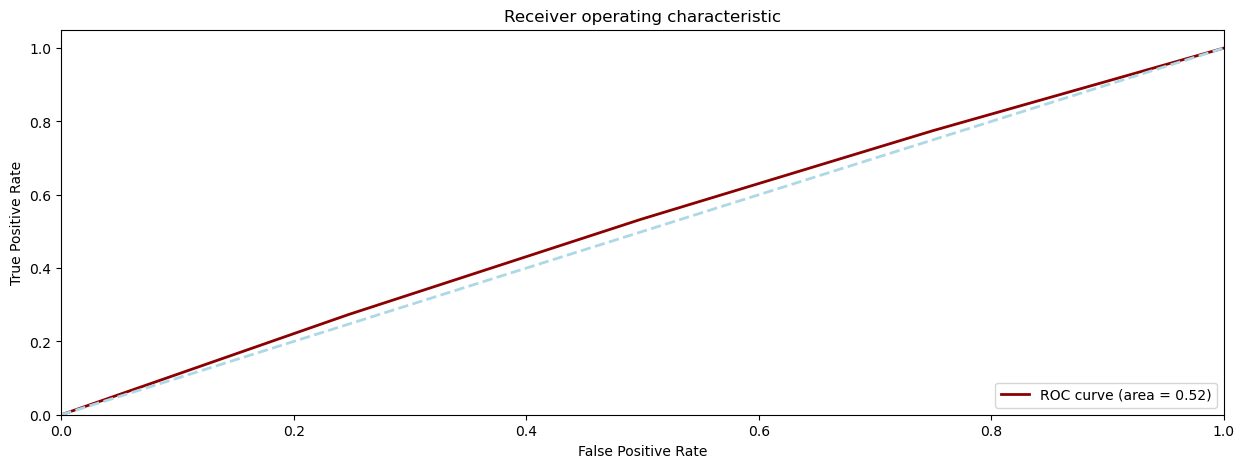

In [20]:
plot_roc_auc_curve(y_true=dataset['eval']['Default'], y_pred=pd_estimates)

# Dataset Preparation

While the dataset in this example is already prepared and "clean", this is usually not the case - not in the real-world and also not in your case study. 

There can be many problem with the data, e.g.:
* special characters
* wrong data types
* missing values
* outliers and extreme values

The following section will give you some ideas on how to prepare your dataset for the analysis.

## Before we really start

### Column names

In real-world applications, the column names are often not very descriptive and or contain special characters. The problem arises often than data is exported from a database with technical column names (not very descriptive) or Excel (special characters like spaces, etc.).

In our example dataset, the column names are already pretty and follow a naming convention (PascalCase). 

If the names are not descriptive, you should rename them. If they contain special characters, you should remove them. Of course, you can also change the naming convention if you want to.
Lets change the column names to lower case and replace the spaces indicated by the CamelCase notation with underscores (snake_case).

In [21]:
print(dataset["train"].columns)

Index(['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
       'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Education',
       'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents',
       'LoanPurpose', 'HasCoSigner', 'Default'],
      dtype='object')


In [23]:
def clean_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """ Cleans the column names of a dataframe.
    
    Args:
        df (pd.DataFrame): The dataframe
        
    Returns:
        pd.DataFrame: The dataframe with cleaned column names.
    """
    df_copy = df.copy()
    old_column_names = df_copy.columns
    new_column_names = ['_'.join(re.findall('[A-Z][^A-Z]*', s)).lower() for s in old_column_names] # split PascalCase
    df_copy.columns = new_column_names

    df_copy = df_copy.rename(columns={'d_t_i_ratio': 'dti_ratio'})
    return df_copy

In [24]:
df_train = clean_column_names(dataset['train'])

In [26]:
print(df_train.columns)

Index(['age', 'income', 'loan_amount', 'credit_score', 'months_employed',
       'num_credit_lines', 'interest_rate', 'loan_term', 'dti_ratio',
       'education', 'employment_type', 'marital_status', 'has_mortgage',
       'has_dependents', 'loan_purpose', 'has_co_signer', 'default'],
      dtype='object')


### Data types

The data types of the variables are important as they determine how you can use the data. For example, you cannot use a categorical variable in a linear regression model. Furthermore, the data types determine how you have to look at the data, e.g. you cannot calculate the mean of a categorical variable.

There are many different data types in Computer Science / Statistics. The most common ones are:
* numerical: integer, float, decimal, ...
* categorical: nominal, ordinal, 
* boolean
* datetime, date, time
* text, string
* ...

More often than not, especially when you import data from text-files like .csv or spreadsheets like Excel, the data types are not correct.
Only think about leading zeros in zip codes or telephone numbers. If you import them as numerical variables, the leading zeros will be removed.
Hence, you should always check the data types of your variables and convert them if necessary or fix them before importing the data.

In our example, we could use pd.read_csv(..., dtype={"default": bool, ...}) to convert the data in the column "default" (0, 1) into booleans.


In our example dataset, the data types are nearly correct (regarding Pandas' data types). Nevertheless, not 100 % correct. Let's fix that. 

In [27]:
df_train.dtypes

age                   int64
income                int64
loan_amount           int64
credit_score          int64
months_employed       int64
num_credit_lines      int64
interest_rate       float64
loan_term             int64
dti_ratio           float64
education            object
employment_type      object
marital_status       object
has_mortgage         object
has_dependents       object
loan_purpose         object
has_co_signer        object
default               int64
dtype: object

In [28]:
dataset["train"].head()

Age  Income  LoanAmount  CreditScore  MonthsEmployed  \
LoanID                                                             
BAAZ3N0MQ2   27   52584       60095          767             110   
MA13MARGJ5   35   52120      110208          719              86   
NLXKBIUR0W   55   97782       85908          629              26   
J2YSSCJ9OY   19   59024       24842          482             114   
LAXP6SKZDF   46  136634      171566          477               4   

            NumCreditLines  InterestRate  LoanTerm  DTIRatio    Education  \
LoanID                                                                      
BAAZ3N0MQ2               3          2.10        60      0.90   Bachelor's   
MA13MARGJ5               2         17.15        12      0.86          PhD   
NLXKBIUR0W               1         18.67        12      0.42  High School   
J2YSSCJ9OY               4         16.79        12      0.41  High School   
LAXP6SKZDF               2          2.81        48      0.31  High School   

           EmploymentType MaritalStatus HasMortgage HasDependents LoanPurpose  \
LoanID                                                                          
BAAZ3N0MQ2      Full-time       Married          No           Yes        Home   
MA13MARGJ5      Part-time      Divorced         Yes           Yes   Education   
NLXKBIUR0W  Self-employed      Divorced         Yes           Yes   Education   
J2YSSCJ9OY      Full-time       Married         Yes            No   Education   
LAXP6SKZDF     Unemployed        Single         Yes           Yes   Education   

           HasCoSigner  Default  
LoanID                           
BAAZ3N0MQ2          No        0  
MA13MARGJ5         Yes        0  
NLXKBIUR0W          No        0  
J2YSSCJ9OY          No        0  
LAXP6SKZDF          No        0

In [29]:
def convert_data_types(df: pd.DataFrame) -> pd.DataFrame:
    """ Converts the data types of the variables in a dataframe.
    
    Args:
        df (pd.DataFrame): The dataframe
        
    Returns:
        pd.DataFrame: The dataframe with converted data types.
    """
    df_copy = df.copy()
    for i in df_copy.columns:
        if (df_copy[i].dtype == 'O') & (df_copy[i].nunique() > 2):
            df_copy[i] = df_copy[i].astype('category')
        elif (df_copy[i].dtype == 'O') & (df_copy[i].nunique() <= 2):
            df_copy[i] = df_copy[i] == 'Yes'
        elif (df_copy[i].dtype == 'int64') & (df[i].unique().tolist() == [0, 1]):
            df_copy[i] = df_copy[i].astype('bool')
        else:
            pass
    return df_copy

In [30]:
df_train = convert_data_types(df_train)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 204277 entries, BAAZ3N0MQ2 to TP14DOJM60
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   age               204277 non-null  int64   
 1   income            204277 non-null  int64   
 2   loan_amount       204277 non-null  int64   
 3   credit_score      204277 non-null  int64   
 4   months_employed   204277 non-null  int64   
 5   num_credit_lines  204277 non-null  int64   
 6   interest_rate     204277 non-null  float64 
 7   loan_term         204277 non-null  int64   
 8   dti_ratio         204277 non-null  float64 
 9   education         204277 non-null  category
 10  employment_type   204277 non-null  category
 11  marital_status    204277 non-null  category
 12  has_mortgage      204277 non-null  bool    
 13  has_dependents    204277 non-null  bool    
 14  loan_purpose      204277 non-null  category
 15  has_co_signer     204277 non-null  bool    

## With some data analysis

### Missing values

Missing values are a common problem in real-world datasets. There are many reasons why values are missing, e.g.:
* the data was not collected
* the data was not available
* the entity rejected to provide the data
* there were errors in the data collection process

There are many ways to deal with missing values, e.g.:
* remove the observations with missing values
* remove the variables with missing values
* simple imputation: mean, median, ...
* impute / model the missing values in a more complex way
* use the missing values as a separate category in categorical variables

Nevertheless, there are some theoretical considerations to be made first. For example, if you have a variable that is missing for a reason, e.g. the customer did not provide the information, then the missing value is not random. In this case, you should not impute the missing value with the mean or median, because this would introduce bias in your dataset. Instead, you should create a new category for the missing values.

Concepts related to missing values include:
* Missing Completely at Random (MCAR)
* Missing at Random (MAR)
* Missing Not at Random (MNAR)

MCAR: the probability of missingness is the same for all observations. This is the case if the missingness is independent of the observed and unobserved data.

MAR: the probability of missingness is the same for all observations given the observed data. This is the case if the missingness is independent of the unobserved data given the observed data.

MNAR: the probability of missingness is not the same for all observations given the observed data. This is the case if the missingness is dependent of the unobserved data given the observed data.

What does this mean for in simpler words?
* MCAR
    * When data is MCAR, the reason for its missingness has nothing to do with the data itself. It's as if someone randomly deleted data points without any pattern or reason.
* MAR: 
    * Data is MAR when the missingness is related to some observed data and not due to the missing data itself. 
    * In other words, once we control for the observed data, the missingness becomes random.
    * Example: Let's say you're conducting a health survey that includes questions about exercise habits and diet. If younger participants are less likely to answer the diet questions, but within age groups, the missingness is random, then the data is MAR. The missingness (not answering diet questions) is related to an observed variable (age), but not directly to the diet questions themselves.
* MNAR:
    * In the case of MNAR, the reason data is missing is directly related to what is missing. This makes it the most challenging type of missing data to deal with, as you can't determine the reason for missingness solely based on the data you have.
    * Consider a survey on sensitive topics, like income. If higher-income individuals are more likely to skip the income question, the missing data is MNAR. The reason for the missing data (discomfort in revealing high income) is directly related to what is missing (the income information itself).

If a variable is MCAR, then you can simply remove the observations with missing values. If a variable is MAR, then you can impute the missing values. If a variable is MNAR, then you should not impute the missing values, but create a new category for the missing values if the variable is categorical. If the variable is numerical, then you should consider removing the variable.

Besides that, you should also consider the amount of missing values in a variable. If there are only a few missing values, then you can impute them. If there are many missing values, then you should consider removing the variable. If there are many missing values in many variables, then you should consider removing the observations with missing values.

With regards to the case study, you should also consider if you are able to "calculate" the value using theoretical balance sheet requirements. Maybe those will give you a hint on how to impute the missing values.

In our example dataset, there are no missing values. Let's create some missing values in the training dataset to demonstrate how to deal with them.

In [34]:
temp_df = df_train.copy(deep=True)

In [35]:
idx_for_na = temp_df.sample(frac=0.1).index

temp_df["credit_score_na"] = np.where(temp_df.index.isin(idx_for_na), np.nan, temp_df.credit_score)
temp_df["income_na"] = np.where(temp_df.income > 125_000, np.nan, temp_df.income)

temp_df["loan_to_income"] = temp_df.loan_amount / temp_df.income
temp_df["loan_term_2"] = (temp_df.loan_to_income * 10 + np.random.normal(0, 5, temp_df.shape[0])).clip(1, 240)
temp_df["loan_term_2_na"] = np.where(temp_df.index.isin(idx_for_na), np.nan, temp_df.loan_term_2)

In [36]:
def make_boxplot_for_na(v_na: str, v: str, data: pd.DataFrame):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    sns.boxplot(y=v_na, data=data, ax=ax[0], color='blue')
    sns.boxplot(y=v, data=data.loc[data[v_na].isna()], ax=ax[1], color='blue')
    ax[0].set_title(v, fontsize=16)
    ax[1].set_title(v_na, fontsize=16)
    ax[0].set_ylim(data[v].min(), data[v].max())
    ax[1].set_ylim(data[v].min(), data[v].max())
    plt.show()

def make_hist_for_na(v_na: str, v: str, data: pd.DataFrame):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    sns.distplot(data[v], ax=ax[0], color='blue')
    sns.distplot(data.loc[data[v_na].isna(), v], ax=ax[1], color='blue')
    ax[0].set_title(v, fontsize=16)
    ax[1].set_title(v_na, fontsize=16)
    plt.show()

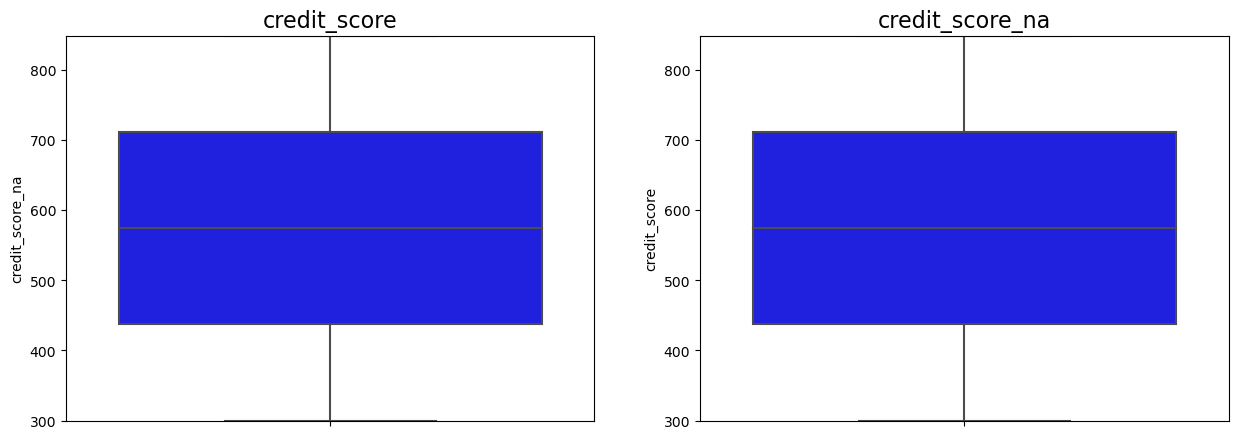

In [37]:
make_boxplot_for_na("credit_score_na", "credit_score", temp_df)

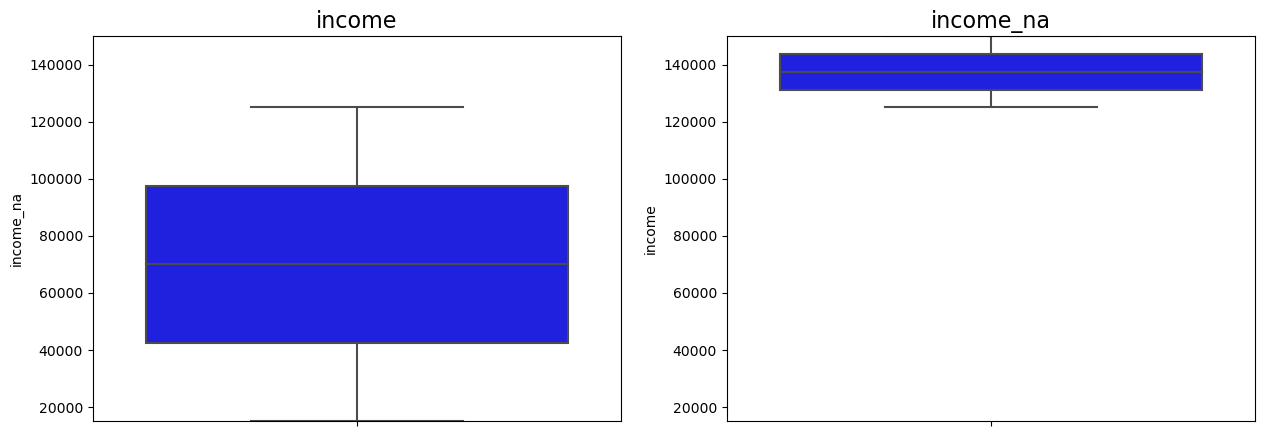

In [38]:
# Income and Income_NA
make_boxplot_for_na("income_na", "income", temp_df)


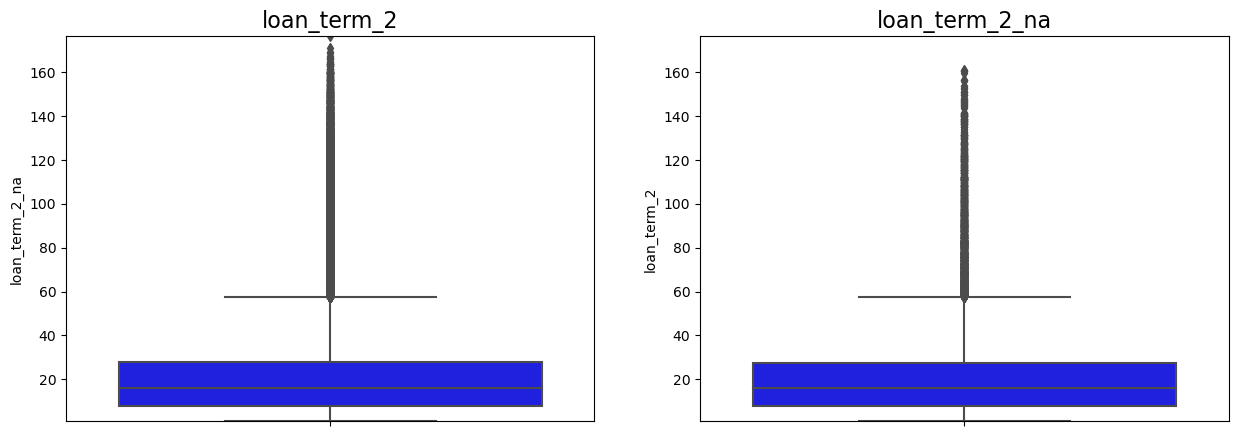

In [40]:
make_boxplot_for_na("loan_term_2_na", "loan_term_2", temp_df)

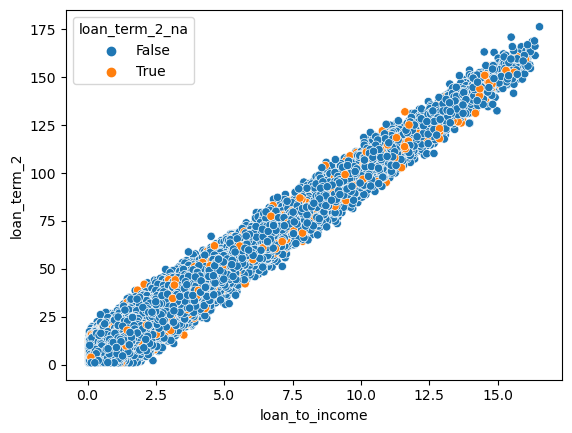

In [41]:
sns.scatterplot(x="loan_to_income", y="loan_term_2", data=temp_df, hue=temp_df.loan_term_2_na.isna());

### Outliers and extreme values

Outliers and extreme values are values that are very different from the other values in the dataset. There are many reasons why outliers and extreme values exist, e.g.:
* measurement errors
* data entry errors
* data processing errors
* extreme values are possible in the population
* 

**What are outliers**
* Outliers are observations that are "far away" from the other observations
* 

**one-dimensional situation**
* loosely defined as values that are "unusually large" or "unusually small"
* but what means unusually?
 
**higher-dimensional cases**
* outliers are points "don't fit the general pattern" of the other data.

**What to do?**
Outliers can cause severe problems for your analysis and you should deal with them

*Deleting outliers / Trimming*
* deleting outliers is - in general - never appropriate simply because they meet your definition of outliers
* you should only delete outliers if you are sure that they are not representative for the population you are interested in (e.g. selected from a non-relevant population, severe data error that you cannot be fixed)
* if you are not sure, you should not delete them, but use robust methods instead
* Trimming: you delete the outliers from your dataset and then run your analysis on the trimmed dataset

*Winsorizing*
* Winsorizing is a special case of trimming, where you don't delete the outliers, but set them to a given value
* e.g. you set all values above the 99th percentile to the 99th percentile
* this is a very conservative approach, because you don't delete the outliers, but only limit their effect on your analysis
* you should only use it if you are sure that the outliers are not representative for the population you are interested or if you assume that the region of the outlier value is not relevant for your analysis (has no predictive power)
* describes the process of limiting extreme values to reduce the effect of possibly spurious outliers (censoring)
* don't mix it up with trimming / truncation!
* Hint: Always think about reasonable minimal and maximal values of your variable - which will make sense? 

*Transformations*
* you can transform your data to reduce the effect of outliers
* e.g. you can use the log-transformation to reduce the effect of extreme values if the variable is right-skewed and always positive (e.g. income)
* there are some techniques which reshape the complete distribution of your data and hence deal with extreme values, e.g. quantile transformation or power transformation
* nevertheless, if there are linear dependencies between some variables, those will be distorted by such transformations!


Our current dataset does not contain any outliers, because it is "special". To demonstrate how to deal with outliers, we will create some outliers in the training dataset.

#### Example 1  

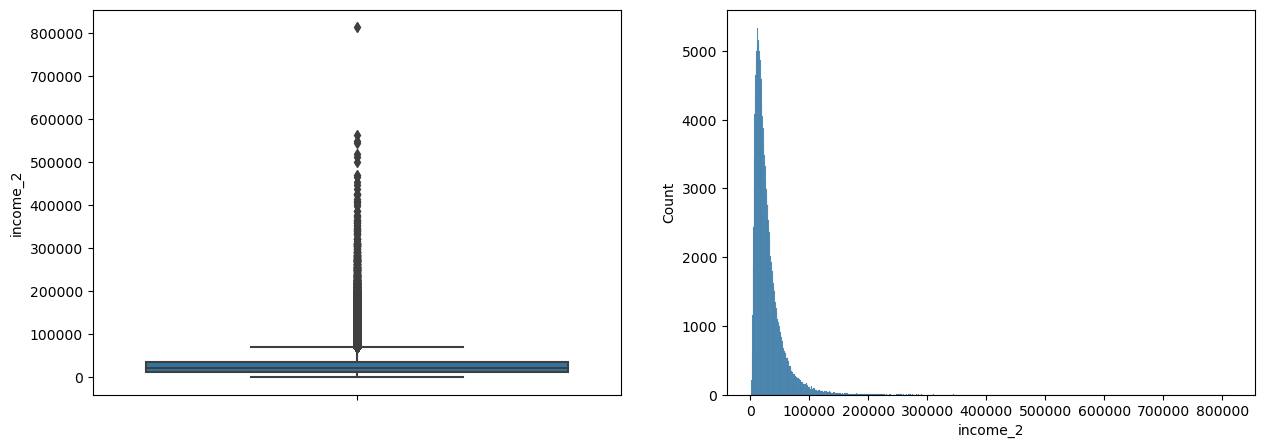

In [42]:
temp_df = df_train.copy(deep=True)
temp_df["income_2"] = np.random.lognormal(10, 0.75, temp_df.shape[0])

fig, ax = plt.subplots(1, 2, figsize=(15,5))
sns.boxplot(data=temp_df, y="income_2", ax=ax[0])
sns.histplot(data=temp_df, x="income_2", ax=ax[1]);

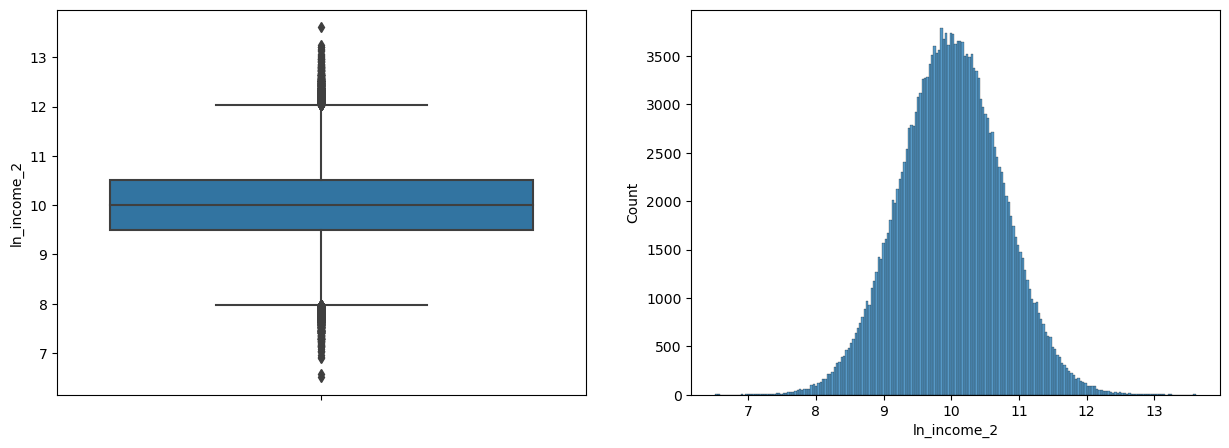

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
sns.boxplot(data=temp_df.assign(ln_income_2=lambda x: np.log(x.income_2)), y="ln_income_2", ax=ax[0])
sns.histplot(data=temp_df.assign(ln_income_2=lambda x: np.log(x.income_2)), x="ln_income_2", ax=ax[1]);

#### Example 2

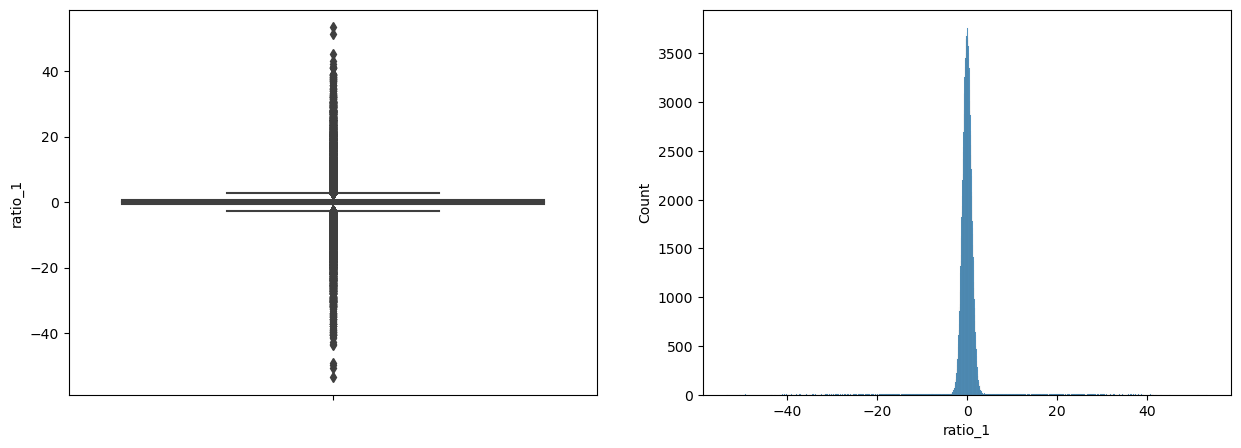

In [44]:
temp_df["ratio_1"] = np.random.normal(0, 1, temp_df.shape[0])

idx_1 = temp_df.sample(frac=0.01).index
idx_2 = temp_df.sample(frac=0.01).index
temp_df.loc[temp_df.index.isin(idx_1), 'ratio_1'] = np.random.normal(3, 15, len(idx_1))
temp_df.loc[temp_df.index.isin(idx_2), 'ratio_1'] = np.random.normal(-3, 15, len(idx_2))
fig, ax = plt.subplots(1, 2, figsize=(15,5))
sns.boxplot(data=temp_df, y="ratio_1", ax=ax[0])
sns.histplot(data=temp_df, x="ratio_1", ax=ax[1]);

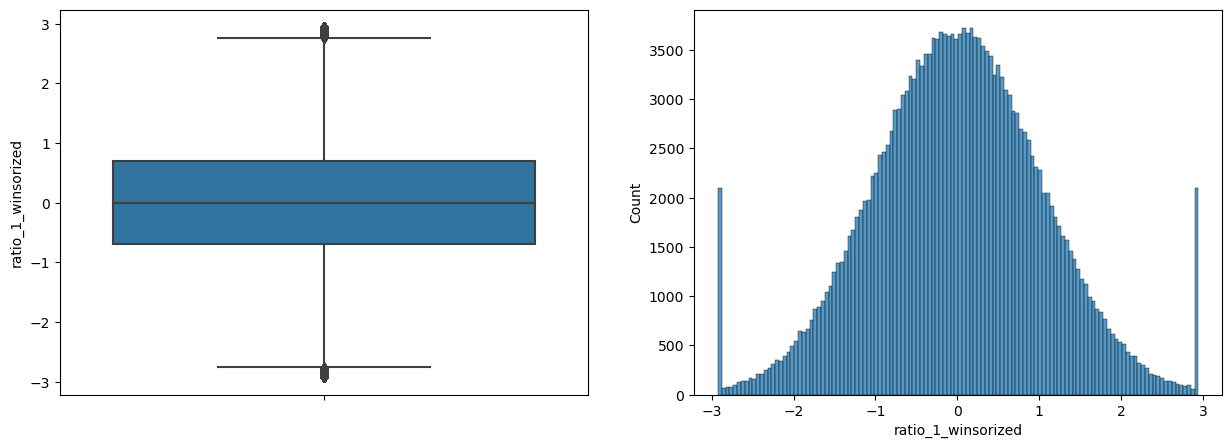

In [45]:
temp_df['ratio_1_winsorized'] = temp_df.ratio_1.clip(lower=temp_df.ratio_1.quantile(0.01), upper=temp_df.ratio_1.quantile(0.99))
fig, ax = plt.subplots(1, 2, figsize=(15,5))
sns.boxplot(data=temp_df, y="ratio_1_winsorized", ax=ax[0])
sns.histplot(data=temp_df, x="ratio_1_winsorized", ax=ax[1]);

## Using a data profiling tool

In [46]:
profile = ProfileReport(df_train, title="Profiling Report of our training dataset")

In [47]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Understanding your data

In this section, we will make descriptive analysis of the data to understand the data better.
Initial data analysis is important before estimating a model, because it helps you to understand the data and to make better decisions regarding the model specification.

## Univariate descriptive analysis

In [48]:
df_train.describe()

age         income    loan_amount   credit_score  \
count  204277.000000  204277.000000  204277.000000  204277.000000   
mean       43.493918   82487.536272  127503.687336     574.233218   
std        14.977712   38956.883836   70872.085904     158.793782   
min        18.000000   15000.000000    5000.000000     300.000000   
25%        31.000000   48795.000000   65904.000000     437.000000   
50%        43.000000   82414.000000  127525.000000     574.000000   
75%        56.000000  116204.000000  189098.000000     712.000000   
max        69.000000  149999.000000  249999.000000     849.000000   

       months_employed  num_credit_lines  interest_rate      loan_term  \
count    204277.000000     204277.000000  204277.000000  204277.000000   
mean         59.575209          2.500081      13.492289      36.020502   
std          34.641230          1.117338       6.632167      16.972980   
min           0.000000          1.000000       2.000000      12.000000   
25%          30.000000          2.000000       7.780000      24.000000   
50%          60.000000          2.000000      13.450000      36.000000   
75%          90.000000          3.000000      19.250000      48.000000   
max         119.000000          4.000000      25.000000      60.000000   

           dti_ratio  
count  204277.000000  
mean        0.500610  
std         0.230839  
min         0.100000  
25%         0.300000  
50%         0.500000  
75%         0.700000  
max         0.900000

In [49]:
for i in df_train.columns:
    print('============================================')
    print(f'Variable: {i} \n')
    if df_train[i].dtype == 'category':
        print(df_train[i].value_counts().transpose())
    elif df_train[i].dtype == 'bool':
        print("Avg: ", df_train[i].astype(int).mean())
    else:
        print(df_train[i].describe().transpose())
    print()

Variable: age 

count    204277.000000
mean         43.493918
std          14.977712
min          18.000000
25%          31.000000
50%          43.000000
75%          56.000000
max          69.000000
Name: age, dtype: float64

Variable: income 

count    204277.000000
mean      82487.536272
std       38956.883836
min       15000.000000
25%       48795.000000
50%       82414.000000
75%      116204.000000
max      149999.000000
Name: income, dtype: float64

Variable: loan_amount 

count    204277.000000
mean     127503.687336
std       70872.085904
min        5000.000000
25%       65904.000000
50%      127525.000000
75%      189098.000000
max      249999.000000
Name: loan_amount, dtype: float64

Variable: credit_score 

count    204277.000000
mean        574.233218
std         158.793782
min         300.000000
25%         437.000000
50%         574.000000
75%         712.000000
max         849.000000
Name: credit_score, dtype: float64

Variable: months_employed 

count    204277.000000
m

## Bivariate descriptive analysis (numerical variables)

In [50]:
y = 'default'
num_variables = [i for i in df_train.columns if df_train[i].dtype in ['int64', 'float64']]
cat_variables = [i for i in df_train.columns if df_train[i].dtype == 'category']
bool_variables = [i for i in df_train.columns if df_train[i].dtype == 'bool' and i != 'default']

age


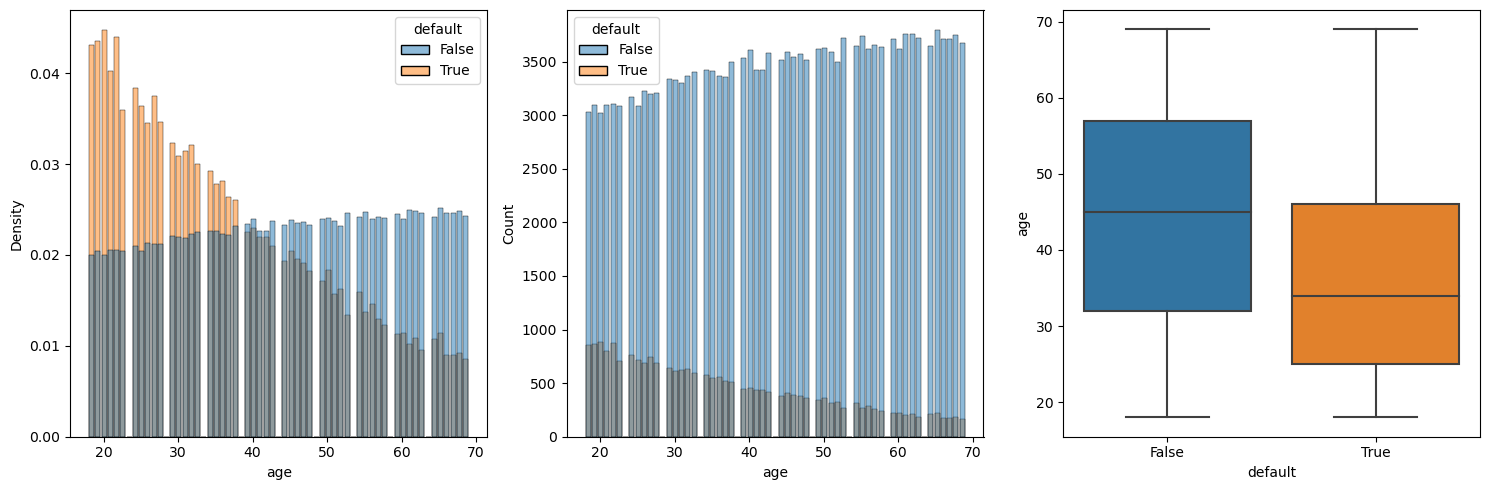

income


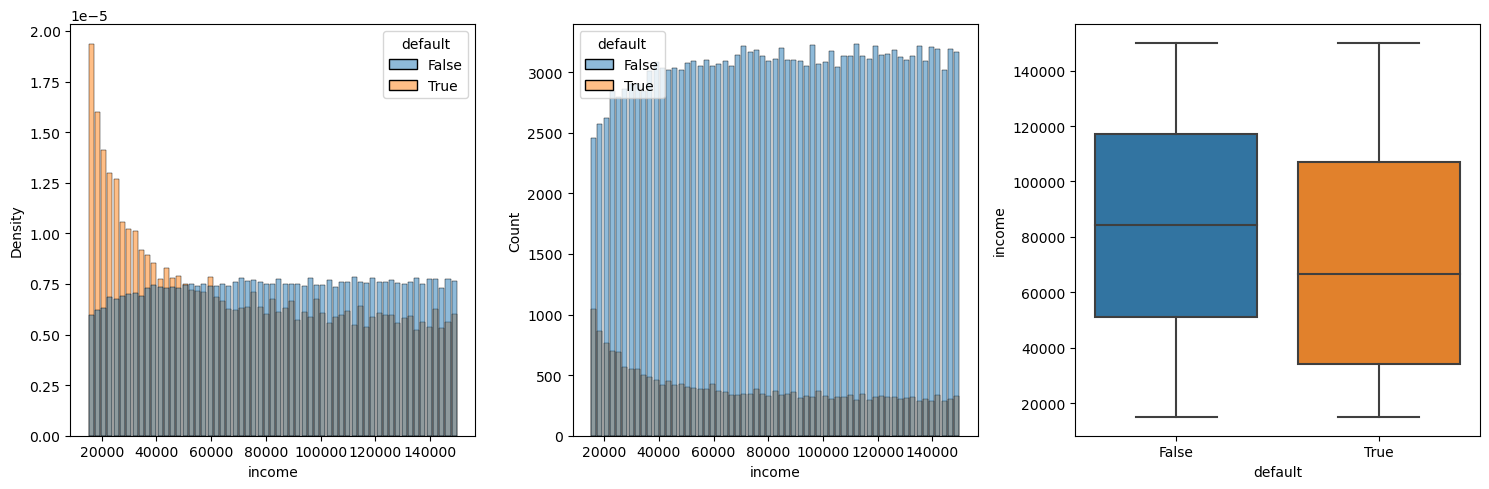

loan_amount


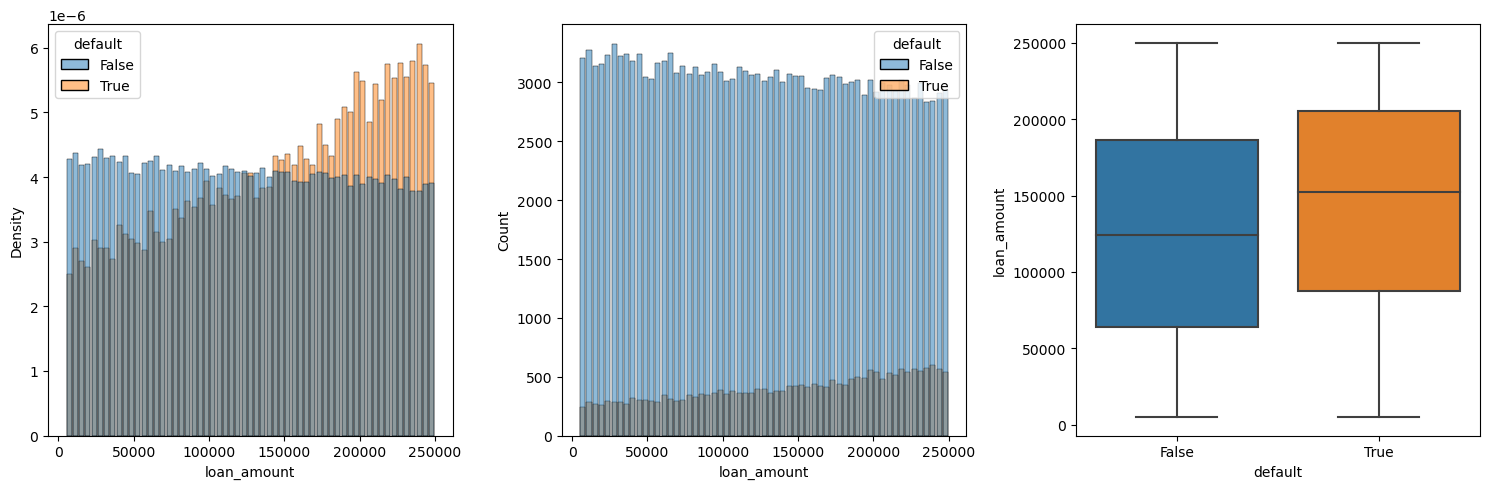

credit_score


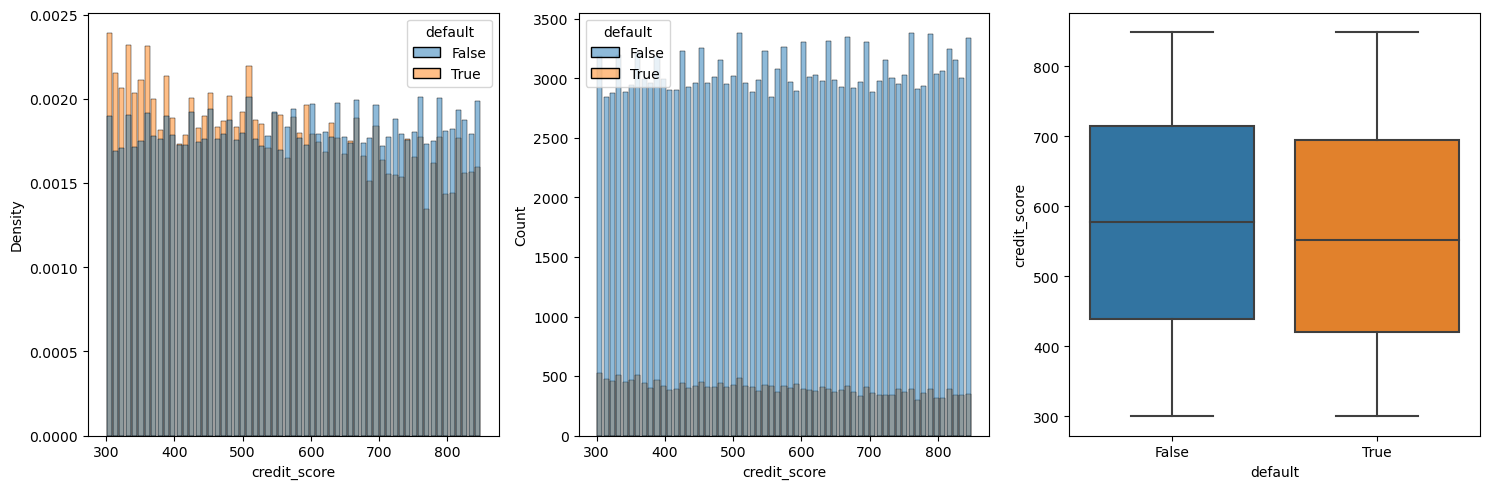

months_employed


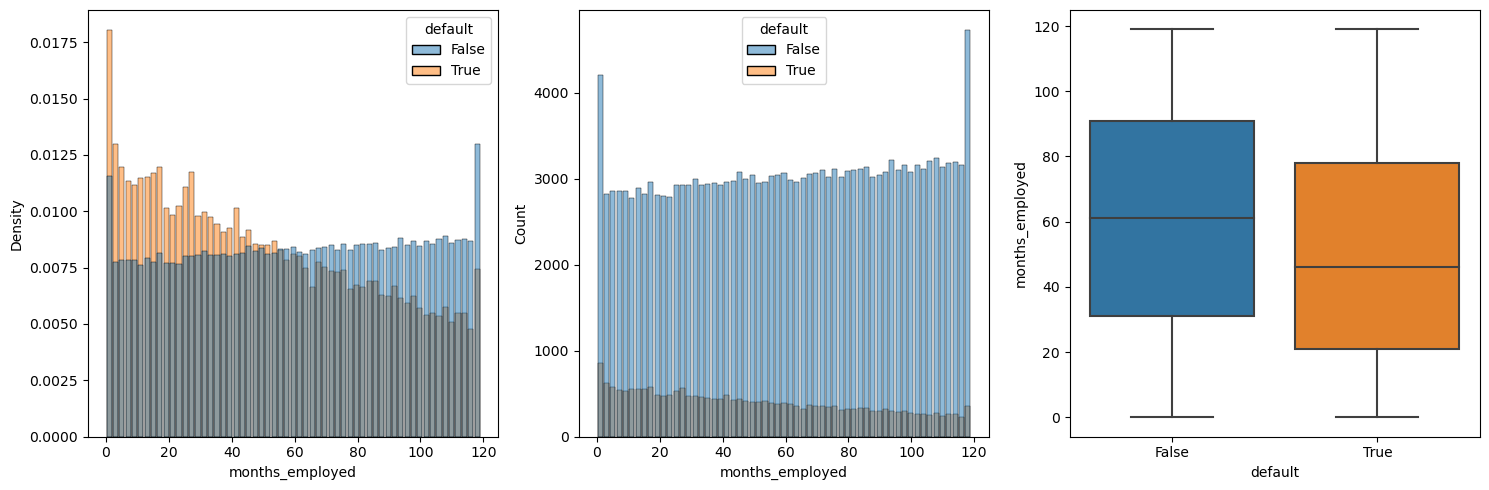

num_credit_lines


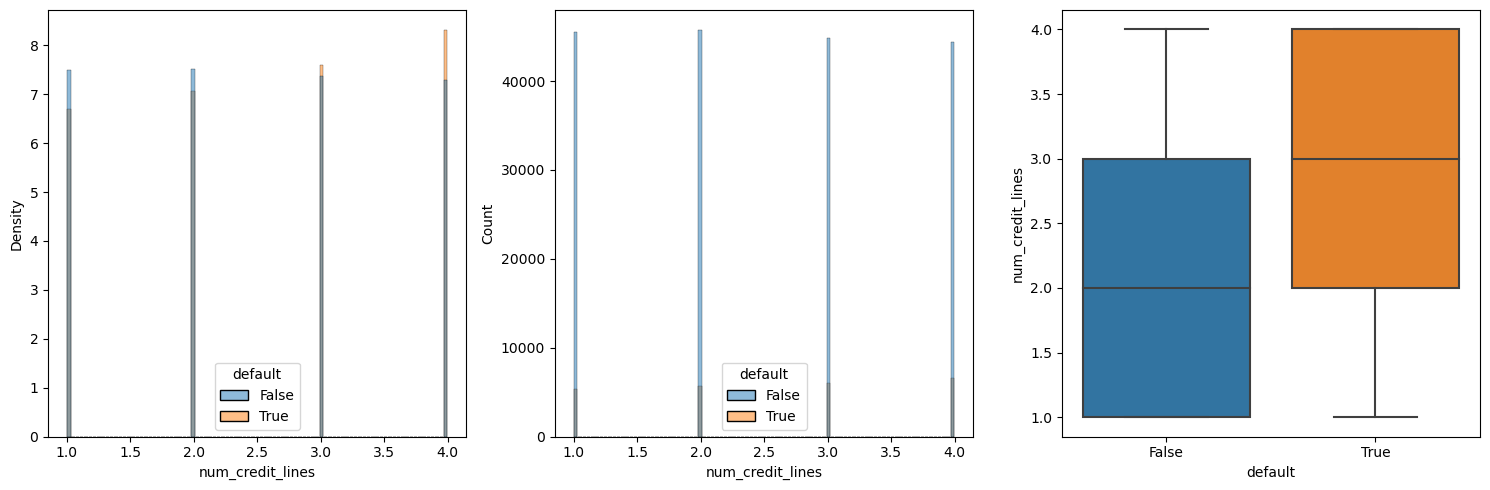

interest_rate


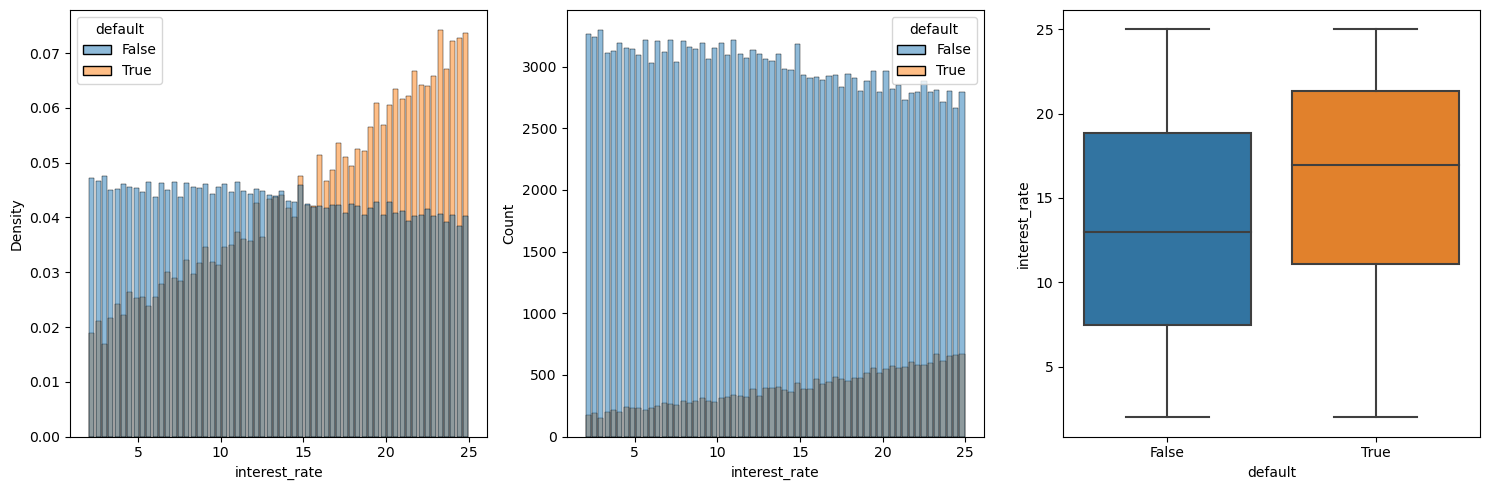

loan_term


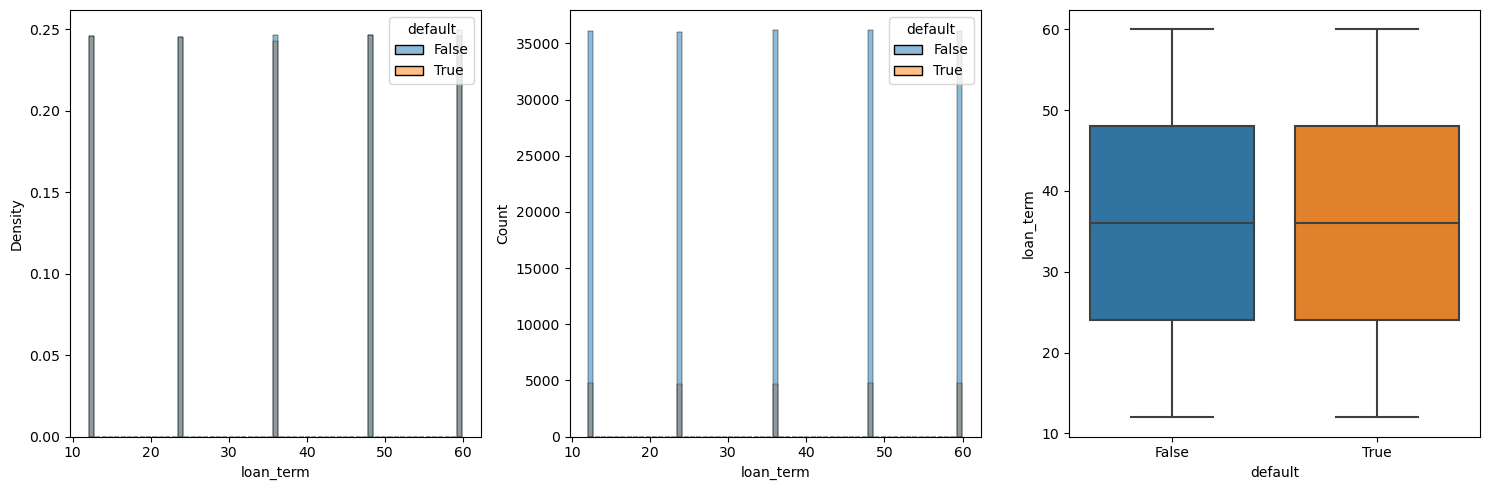

dti_ratio


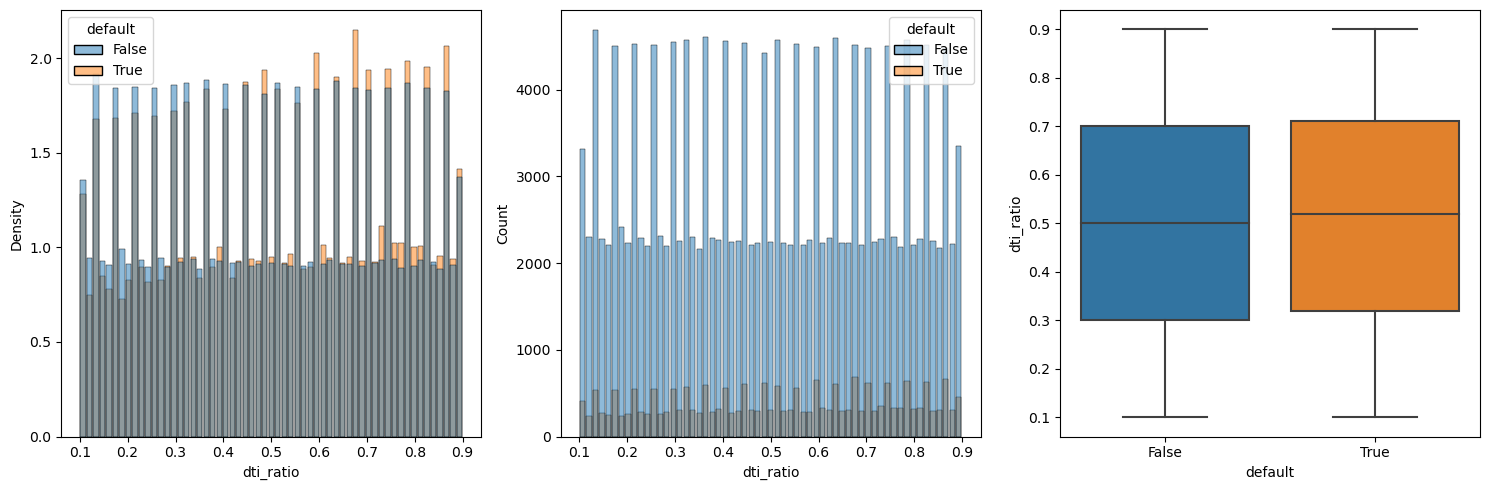

In [51]:
for i in num_variables:
    print("============================================")
    print(i)
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    sns.histplot(data=df_train, x=i, hue=y, shrink=.8, stat="density", common_norm=False, ax=ax[0]);
    sns.histplot(data=df_train, x=i, hue=y, shrink=.8, stat="count", common_norm=False, ax=ax[1]);
    sns.boxplot(data=df_train, y=i, x=y, ax=ax[2]);
    fig.tight_layout()
    plt.show()

## Correlations with the target variable

In [52]:
corrs = df_train[num_variables+[y]].corr(method='pearson')['default'].sort_values(ascending=False).iloc[1:]
corrs = corrs.to_frame('pearson')
corrs['spearman'] = df_train[num_variables+[y]].corr(method='spearman')['default'].sort_values(ascending=False).iloc[1:]
corrs['kendall'] = df_train[num_variables+[y]].corr(method='kendall')['default'].sort_values(ascending=False).iloc[1:]
corrs

pearson  spearman   kendall
interest_rate     0.131418  0.131385  0.107299
loan_amount       0.084923  0.084931  0.069346
num_credit_lines  0.029245  0.029242  0.026694
dti_ratio         0.020881  0.020882  0.017155
loan_term         0.001282  0.001283  0.001148
credit_score     -0.034229 -0.034231 -0.027975
months_employed  -0.096823 -0.096820 -0.079382
income           -0.098489 -0.098481 -0.080410
age              -0.168075 -0.168089 -0.138558

## Bivariate descriptive analysis (categorical and boolean variables)

In [53]:
train_dr = df_train[y].mean()
print("Default rate in training dataset: ", train_dr)

for i in cat_variables+bool_variables:
    print("============================================")
    tmp = df_train.groupby(i)[y].agg(["mean", "count", "sum"]).sort_values("mean").round(4)
    print(tmp)
    print("\n")

Default rate in training dataset:  0.11588676160311734
               mean  count   sum
education                       
PhD          0.1053  50913  5359
Master's     0.1080  50756  5482
Bachelor's   0.1212  51484  6241
High School  0.1289  51124  6591


                   mean  count   sum
employment_type                     
Full-time        0.0950  51077  4854
Self-employed    0.1153  50871  5864
Part-time        0.1183  51424  6086
Unemployed       0.1349  50905  6869


                  mean  count   sum
marital_status                     
Married         0.1042  68303  7118
Single          0.1184  68085  8062
Divorced        0.1251  67889  8493


                mean  count   sum
loan_purpose                     
Home          0.1030  40946  4216
Other         0.1173  40639  4768
Education     0.1182  40812  4826
Auto          0.1186  40619  4816
Business      0.1223  41261  5047


                mean   count    sum
has_mortgage                       
True          0.1090  10195

In [54]:
for i in cat_variables+bool_variables:
    print("============================================")
    tmp = df_train.groupby(i)[y].agg(["mean", "count", "sum"]).sort_values("mean").round(4)
    tmp['diff'] = tmp['mean'] - train_dr
    tmp['diff_rel'] = tmp['diff'] / train_dr
    tmp["binom_pval"] = tmp.apply(lambda x: np.round(sci.stats.binom_test(x['sum'], x['count'], train_dr), 8), axis=1)
    print(tmp)
    print("\n")

               mean  count   sum      diff  diff_rel    binom_pval
education                                                         
PhD          0.1053  50913  5359 -0.010587 -0.091354  0.000000e+00
Master's     0.1080  50756  5482 -0.007887 -0.068056  2.000000e-08
Bachelor's   0.1212  51484  6241  0.005313  0.045849  1.705700e-04
High School  0.1289  51124  6591  0.013013  0.112293  0.000000e+00


                   mean  count   sum      diff  diff_rel  binom_pval
employment_type                                                     
Full-time        0.0950  51077  4854 -0.020887 -0.180234    0.000000
Self-employed    0.1153  50871  5864 -0.000587 -0.005063    0.672681
Part-time        0.1183  51424  6086  0.002413  0.020824    0.081375
Unemployed       0.1349  50905  6869  0.019013  0.164067    0.000000


                  mean  count   sum      diff  diff_rel  binom_pval
marital_status                                                     
Married         0.1042  68303  7118 -0.01168

# A simple regression example 

## Linear Regression vs. Logistic Regression

**Always a good idea?**

In [55]:
model = smf.ols(formula='default ~ income', data=df_train.assign(default = lambda x: x.default.astype(int)))
res = model.fit()
print(res.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.010      
Dependent Variable: default          AIC:                112319.1342
Date:               2023-11-18 14:13 BIC:                112339.5886
No. Observations:   204277           Log-Likelihood:     -56158.    
Df Model:           1                F-statistic:        2001.      
Df Residuals:       204275           Prob (F-statistic): 0.00       
R-squared:          0.010            Scale:              0.10146    
----------------------------------------------------------------------
             Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
----------------------------------------------------------------------
Intercept    0.1826     0.0017   110.6673   0.0000    0.1794    0.1859
income      -0.0000     0.0000   -44.7312   0.0000   -0.0000   -0.0000
--------------------------------------------------------------------
Omnibus:            89797.287      Durbin-W

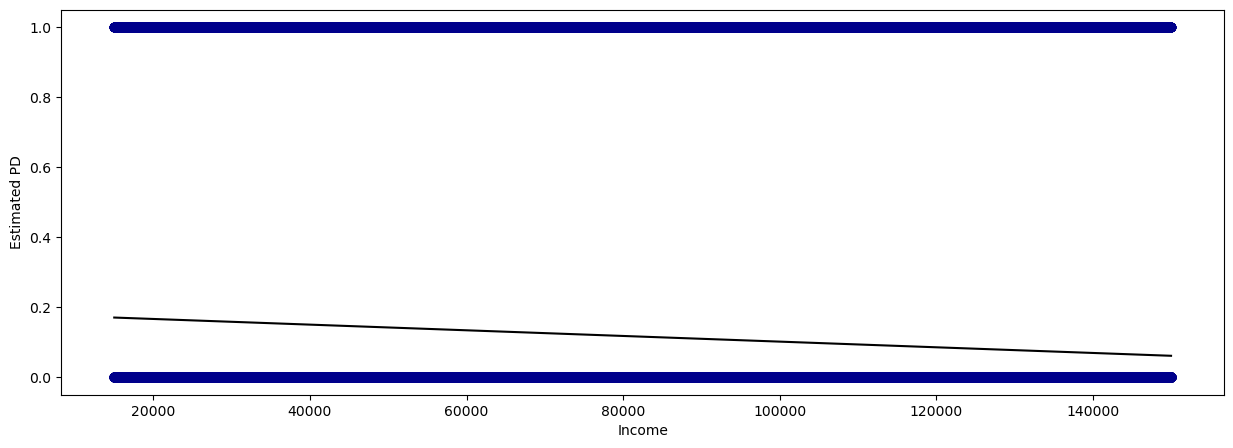

In [57]:
fig, ax = plt.subplots(1, figsize=(15,5))

xs = np.arange(df_train.income.min(), df_train.income.max(), 1)
ys = res.params[0] + res.params[1] * xs

ax = plt.scatter(df_train.income, df_train.default, color='darkblue')
ax = plt.plot(xs,ys, color='black')

plt.xlabel('Income')
plt.ylabel('Estimated PD');

It makes sense to run a OLS regression for binary variable, because it can be shown that it delivers an estimate for $P(\text{default}=\text{True}|X)$.

**Nevertheless**
* some of our estimates might be outside the [0, 1] interval -- hard to interpret as probabilities
* the marginal effect of an variable is independent of it's level (e.g. the effect of an increase of 100 on the PD is the same for everybody, independent of the \textt{income} )
*  ...

What happens if someone applies for a loan with an income of 300.000 ? 

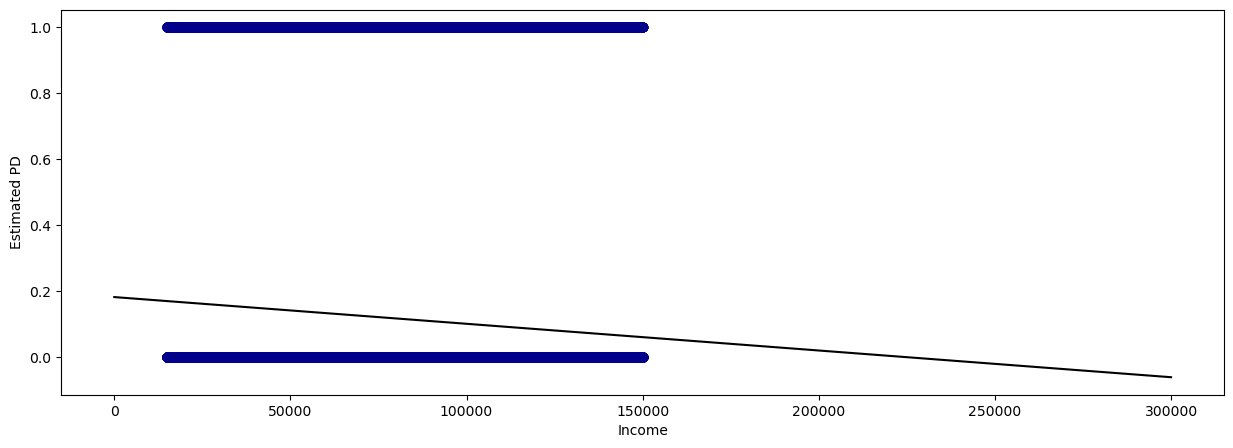

In [58]:
fig, ax = plt.subplots(1, figsize=(15, 5))

xs = np.arange(1, df_train.income.max() + 150_000, 1)
ys = res.params[0] + res.params[1] * xs

ax = plt.scatter(df_train.income, df_train.default, color='darkblue')
ax = plt.plot(xs, ys, color='black')

plt.xlabel('Income')
plt.ylabel('Estimated PD');

**Logistic Regression**

Approach to model $P(\text{default}=\text{True}|X)$ using a function that gives outputs between 0 and 1 for all values of $X$

Some formulas 

$p(\text{default=True}|X) = \dfrac{e^{\boldsymbol{X}'\boldsymbol{b}}}{1 + e^{\boldsymbol{X}'\boldsymbol{b}}}$

$\text{Odds: } \; \dfrac{p(\text{default=True}|X)}{1- p(\text{default=True}|X)} = e^{\boldsymbol{X}'\boldsymbol{b}} > 0$

$\text{Log-Odds: } \; \ln\Big(\dfrac{p(\text{default=True}|X)}{1- p(\text{default=True}|X)}\Big) = {\boldsymbol{X} ' \boldsymbol{b}}$

In [59]:
res2 = sm.Logit.from_formula('default ~ income + 1', data=df_train.assign(default = lambda x: x.default.astype(int))).fit(disp=False, maxiter=100)
print(res2.summary2())

                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.014      
Dependent Variable: default          AIC:              144532.6199
Date:               2023-11-18 14:18 BIC:              144553.0744
No. Observations:   204277           Log-Likelihood:   -72264.    
Df Model:           1                LL-Null:          -73264.    
Df Residuals:       204275           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
Intercept     -1.4064    0.0150  -93.4952  0.0000  -1.4359  -1.3769
income        -0.0000    0.0000  -44.1295  0.0000  -0.0000  -0.0000



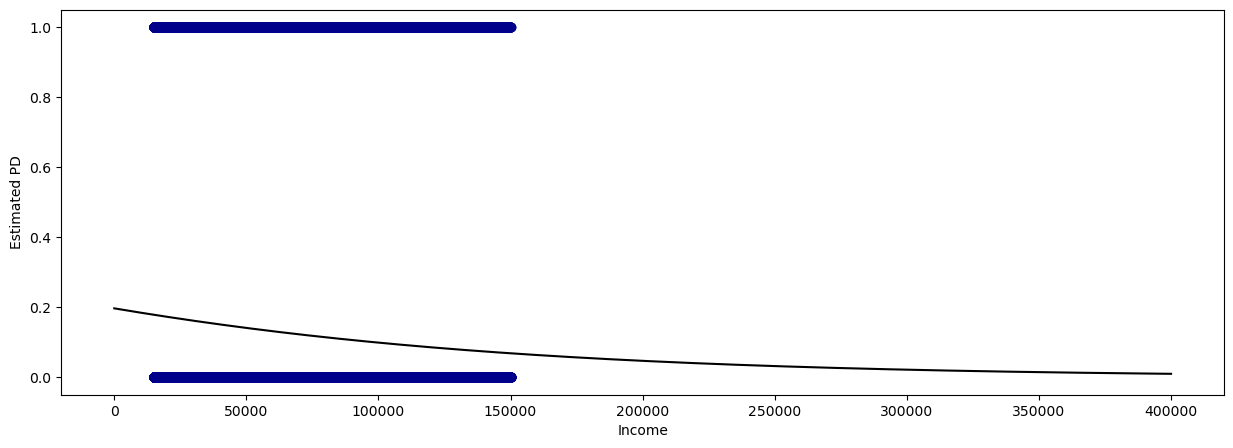

In [61]:
fig, ax = plt.subplots(1, figsize=(15, 5))

xs = np.arange(1, df_train.income.max() + 250_000, 1)
ys = res2.predict(exog=pd.DataFrame({'income': xs}))

ax = plt.scatter(df_train.income, df_train.default, color='darkblue')
ax = plt.plot(xs, ys, color='black')

plt.xlabel('Income')
plt.ylabel('Estimated PD');

## How can we include categorical variables?

To include categorical variables in a regression model, we have to create dummy variables.
The number of dummy variables is equal to the number of categories minus one.
One is missing, because the information of the dummy variables is redundant and can be derived from the other dummy variables.
Otherwise, we would have perfect multicollinearity in our model and would get an error.

The process of creating dummy variables is called "dummy coding" or "one-hot encoding".

Let's remember the information we already have about the education of the customers. What could be a reasonable way to create dummy variables?

In [62]:
temp_df = df_train.copy(deep=True).assign(default = lambda x: x.default.astype(int))

tmp = pd.get_dummies(df_train.education.str.lower().str.replace("'", "").str.replace(" ","_"), prefix='edu')
temp_df["edu_ms_phd"] = (tmp.edu_masters + tmp.edu_phd) > 0

In [65]:
res3 = sm.Logit.from_formula('default ~ income + edu_ms_phd + 1', data=temp_df).fit(disp=False, maxiter=100)
print(res3.summary2())

                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.015      
Dependent Variable:  default          AIC:              144363.8473
Date:                2023-11-18 14:22 BIC:              144394.5290
No. Observations:    204277           Log-Likelihood:   -72179.    
Df Model:            2                LL-Null:          -73264.    
Df Residuals:        204274           LLR p-value:      0.0000     
Converged:           1.0000           Scale:            1.0000     
No. Iterations:      6.0000                                        
-------------------------------------------------------------------
                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
Intercept          -1.3185   0.0164 -80.3584 0.0000 -1.3507 -1.2864
edu_ms_phd[T.True] -0.1818   0.0139 -13.0483 0.0000 -0.2092 -0.1545
income             -0.0000   0.0000 -44.1431 0.0000 -0.0000 -0.0000



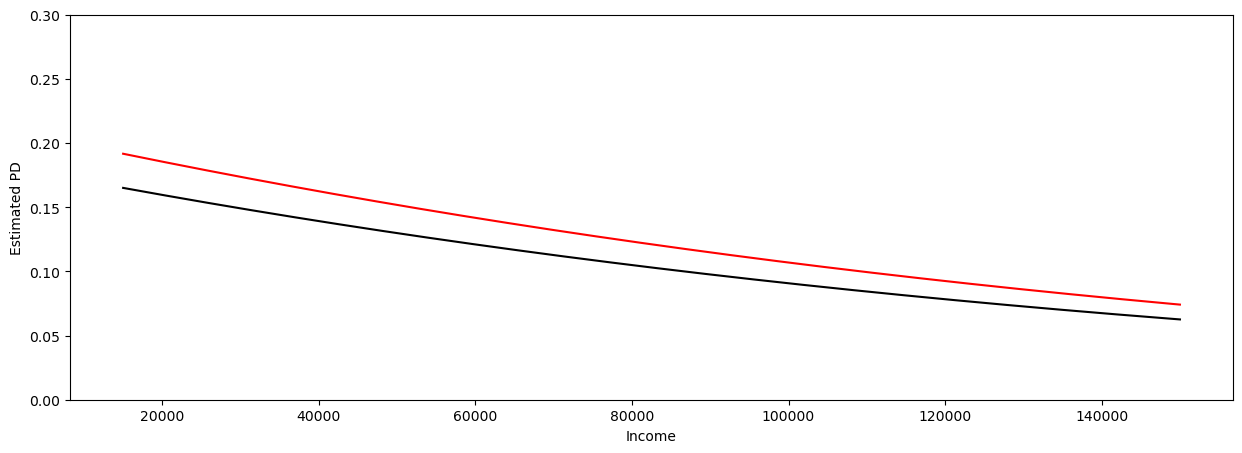

In [66]:
fig, ax = plt.subplots(1, figsize=(15, 5))

xs = np.arange(df_train.income.min(), df_train.income.max(), 1)
ys = res3.predict(exog=pd.DataFrame({'income': xs, 'edu_ms_phd': True}))
ys2 = res3.predict(exog=pd.DataFrame({'income': xs, 'edu_ms_phd': False}))

ax = plt.plot(xs, ys, color='black')
ax = plt.plot(xs, ys2, color='red')

plt.ylim(0, 0.3)

plt.xlabel('Income')
plt.ylabel('Estimated PD');